# Random Forest Estimate in High Dimensions
In this notebook, we will study convergence rates when the dimension of our data grows. To do so, we will be sampling data in increasing dimensions. The data will be similar to the case in the notebook Simple Converge Tests except instead of univariate normal we will use multivariate. The covariance matrix will be the identity matrix for now. Thus we describe our study as follows:

Let $(\boldsymbol{X_i}, Y_i)$ be drawn such that $Y \sim Bernoulli(1/2)$ ($Y$ = -1 or 1) and $\boldsymbol X \sim \mathcal{N_d}(y\mu_1, \dots, y\mu_d, \boldsymbol I)$  

To further simplifiy the problem, we will have one mean equal mu and the rest be 0.

## Sampling code

In [1]:
import numpy as np

def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return x_sample, y_sample

Let's validate that this sampling code is working by visualizing it with d = 2:

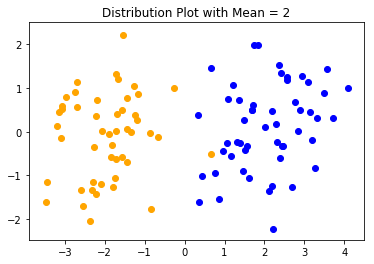

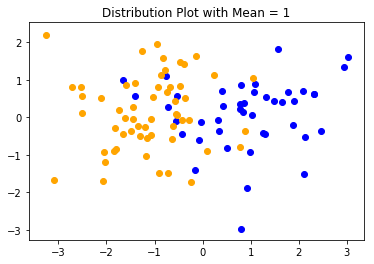

In [3]:
import matplotlib.pyplot as plt

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(100, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


Ok, our sampling code is working. Now let's do a quick convergence test as n-> infinity when d = 1 and d = 2 and try see if the rates are different.

## Original Algorithm Code

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def estimate_conditional_entropy(X, y, n_trees = 10, max_depth = None, bootstrap = False):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = max_depth, random_state = 0)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

# Out of Bag Sampling Code

In [6]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

def rf_entropy_estimate_bagging(X, y, n_estimators = 500, max_samples = .63, bootstrap = True, depth = 4):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        #print(node_counts)
        #print(X[unsampled_indices])
        # get counts for out of bag samples
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[unsampled_indices])])
        #print(partition_counts)
        # get probability for out of bag samples
        class_probs = tree.predict_proba(X[unsampled_indices])
        # find total elements for out of bag samples
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')


100%|██████████| 49/49 [01:15<00:00,  2.63s/it]


0.3504627209867121


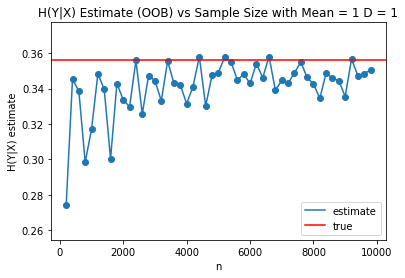

In [15]:
np.warnings.filterwarnings('ignore')
from tqdm import tqdm

def get_cond_entropy_vs_n(mean, d, depth):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in tqdm(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X), y, 200, depth, bootstrap = False))
    return sample_sizes, conditional_entropy

def get_cond_entropy_vs_n_oob(mean, d, depth):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in tqdm(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 200, .63, bootstrap = True, depth = depth))
    return sample_sizes, conditional_entropy


sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 1, 4)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 1")
plt.show()

0.3547996998328199


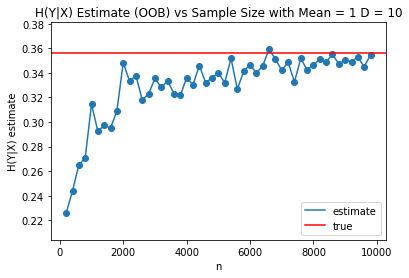

In [9]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 10, 4)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 10")
plt.show()

0.2907270719039566


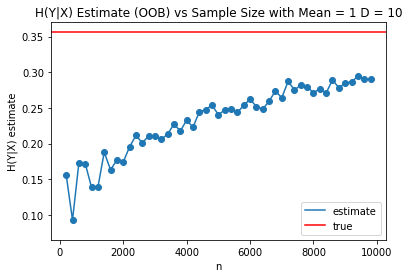

In [10]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 10, 10)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 10")
plt.show()

## What do we realize for the OOB Algorithm?

In the first two plots, we see what we expect which is good! Under a fixed depth, the setting with more dimensions (the second plot) takes more samples before convergence than when d = 1. Furthermore, they both converge to the same conditional entropy value which is expected since mutual information does not change when you add a noise dimension.

Now, for the third plot, we adjust the max depth of the tree from 4 to 10. We disappointingly note that depth changes the convergence rate very drastically. We are not sure if this will even converge to the correct value in this case. To see if depth = 4 will always be enough when mean = 1, we will try changing dimension to 40.

0.34602552975021095


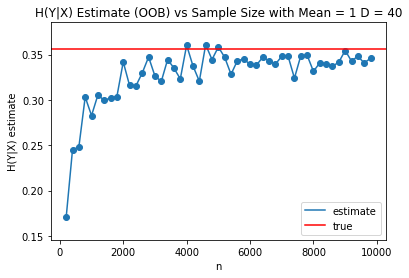

In [32]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 40, 4)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 40")
plt.show()

Very good! OOB seems to be pretty robust in terms of dimension.


Let's see how the normal random forest estimate works. I believe from past experiments, that it is a lot less robust but we will make sure below.

100%|██████████| 49/49 [01:40<00:00,  3.57s/it]

0.3632761407897972


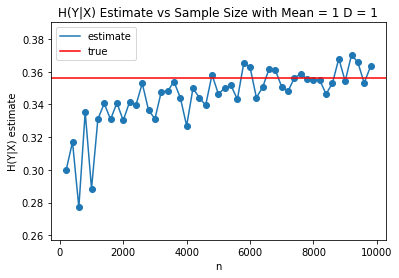

In [17]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, 1, 4)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1 D = 1")
plt.show()

100%|██████████| 49/49 [02:28<00:00,  5.84s/it]

0.5934448928804705


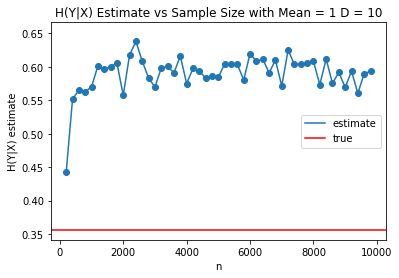

In [18]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, 10, 4)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1 D = 10")
plt.show()

This seems to show that with depth of 4, we do not have enough "power" (probably not correct usage of term) to actually find anything. If we drop depth appropriately...

100%|██████████| 49/49 [04:00<00:00, 10.04s/it]

0.39370730524049996


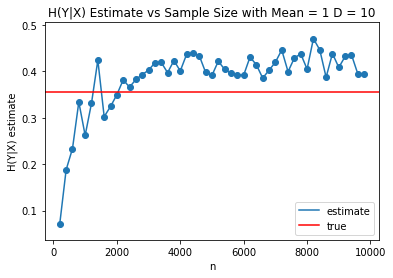

In [19]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, 10, 10)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1 D = 10")
plt.show()

Although this seems better, remember that for this algorithm, the larger we set our depth, the more our estimate will converge to 0. So I'm unsure if this is the correct thing to do. For now, since 1-10 dimensions seem to work with depth = 4 for OOB algorithm, we will make a plot comparing dimension and convergence. However, a lot of work probably needs to be done.

# Samples to Convergence vs Dimension
We will define convergence as 4 points in a row (each point is 50 samples away from the next) where the values are all between .356 +/- .015 (setting is mean = 1). Though this seems like a large range, it's because there seems to be cases where we don't actually reach .356 at all (small bias). Also, the estimate rarely goes above the true value so the range is technically just .015 instead of .03.

First, we find out where dimension gets too large and everything breaks :(

0.3450201780994377


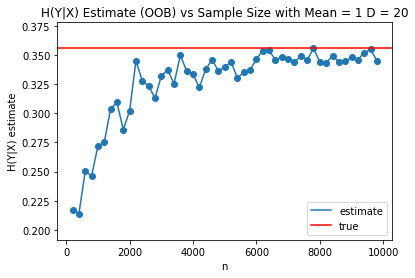

In [27]:
def get_cond_entropy_vs_n_oob(mean, d, depth):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in (sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 200, .63, bootstrap = True, depth = depth))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 20, 4)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 20")
plt.show()

0.34516746567871914


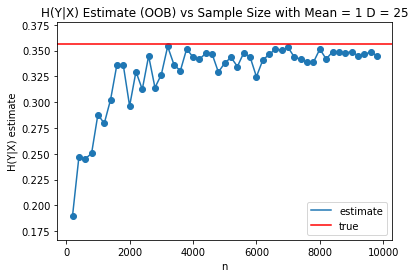

In [29]:
#sample_sizes, cond_entropy = get_cond_entropy_vs_n_oob(1, 25, 4)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate (OOB) vs Sample Size with Mean = 1 D = 25")
plt.show()

600


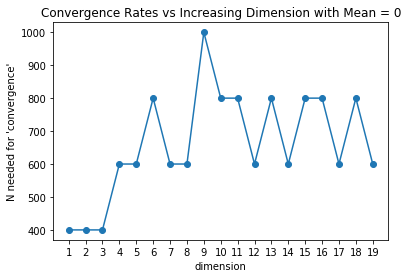

In [65]:
def get_conv_n_vs_d(mean, max_dim, true_cond_entropy, depth = 4):
    dims = [i for i in range(1, max_dim)]
    conv_n = []
    for d in dims:
        converged = False
        # n cannot be 0 
        n = 0
        while (not converged):
            n += 400
            prev_4 = [n - i*50 for i in range(0, 3)]
            converged = True
            for prev in prev_4:
                X, y = get_multivariate_sample(prev, d, mean)
                cond_entropy = rf_entropy_estimate_bagging(np.array(X), y, 200, .63, bootstrap = True, depth = depth)
                if (cond_entropy <= true_cond_entropy + .015 and cond_entropy >= true_cond_entropy - .015):
                    continue
                else:
                    converged = False
            if n > 20000:
                print("failed to converge")
                return dims, conv_n
        print(n)
        conv_n.append(n)
    return dims, conv_n

#dims, conv_n = get_conv_n_vs_d(0, 20, .693)
print(conv_n[-1])
plt.scatter(dims, conv_n)
line_est, = plt.plot(dims, conv_n)
plt.xlabel("dimension")
plt.xticks(dims)
plt.ylabel("N needed for 'convergence'")
plt.title("Convergence Rates vs Increasing Dimension with Mean = 0")
plt.show()

In [55]:
print(conv_n)

[400, 400, 400, 600, 600, 800, 600, 600, 1000, 800, 800, 600, 800, 600, 800, 800, 600, 800, 600]


3600
6800
5600
4000
6000
7600
6400
5200
6800
8400
4800
5200
8800
6400
6400


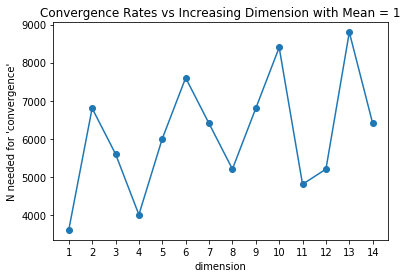

In [66]:
dims, conv_n = get_conv_n_vs_d(1, 15, .356)
print(conv_n[-1])
plt.scatter(dims, conv_n)
line_est, = plt.plot(dims, conv_n)
plt.xlabel("dimension")
plt.xticks(dims)
plt.ylabel("N needed for 'convergence'")
plt.title("Convergence Rates vs Increasing Dimension with Mean = 1")
plt.show()

2400
4400
2800
3600
4400
6400
6400
5600
6000
8000
5200
6000
6800
7200
7200


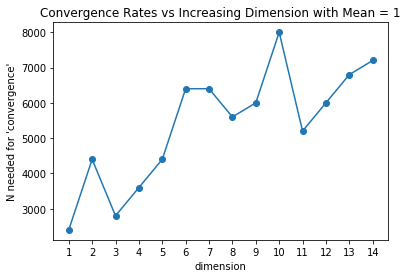

In [67]:
def get_conv_n_vs_d(mean, max_dim, true_cond_entropy, depth = 4):
    dims = [i for i in range(1, max_dim)]
    conv_n = []
    for d in dims:
        converged = False
        # n cannot be 0 
        n = 0
        while (not converged):
            n += 400
            prev_4 = [n - i*100 for i in range(0, 3)]
            converged = True
            for prev in prev_4:
                X, y = get_multivariate_sample(prev, d, mean)
                cond_entropy = rf_entropy_estimate_bagging(np.array(X), y, 200, .63, bootstrap = True, depth = depth)
                if (cond_entropy <= true_cond_entropy + .015 and cond_entropy >= true_cond_entropy - .015):
                    continue
                else:
                    converged = False
            if n > 20000:
                print("failed to converge")
                return dims, conv_n
        print(n)
        conv_n.append(n)
    return dims, conv_n

dims, conv_n = get_conv_n_vs_d(1, 15, .356)
print(conv_n[-1])
plt.scatter(dims, conv_n)
line_est, = plt.plot(dims, conv_n)
plt.xlabel("dimension")
plt.xticks(dims)
plt.ylabel("N needed for 'convergence'")
plt.title("Convergence Rates vs Increasing Dimension with Mean = 1")
plt.show()

4800
5600
8400
5600
5600
7600
6800
6800


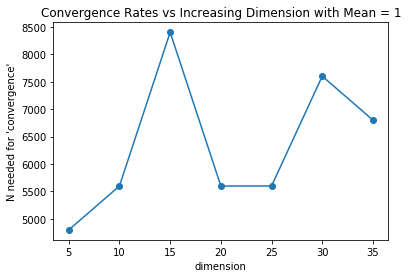

In [68]:
def get_conv_n_vs_d(mean, max_dim, true_cond_entropy, depth = 4):
    dims = [5*i for i in range(1, max_dim)]
    conv_n = []
    for d in dims:
        converged = False
        # n cannot be 0 
        n = 0
        while (not converged):
            n += 400
            prev_4 = [n - i*100 for i in range(0, 3)]
            converged = True
            for prev in prev_4:
                X, y = get_multivariate_sample(prev, d, mean)
                cond_entropy = rf_entropy_estimate_bagging(np.array(X), y, 200, .63, bootstrap = True, depth = depth)
                if (cond_entropy <= true_cond_entropy + .015 and cond_entropy >= true_cond_entropy - .015):
                    continue
                else:
                    converged = False
            if n > 20000:
                print("failed to converge")
                return dims, conv_n
        print(n)
        conv_n.append(n)
    return dims, conv_n

dims, conv_n = get_conv_n_vs_d(1, 8, .356)
print(conv_n[-1])
plt.scatter(dims, conv_n)
line_est, = plt.plot(dims, conv_n)
plt.xlabel("dimension")
plt.xticks(dims)
plt.ylabel("N needed for 'convergence'")
plt.title("Convergence Rates vs Increasing Dimension with Mean = 1")
plt.show()